In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

sns.set(style="whitegrid")

### 1 – Considere	a	base	de	dados:
https://www.kaggle.com/fschwartzer/tmd-dataset-5-seconds-sliding-window

In [4]:
# Leitura dos datasets:
dataset = pd.read_csv('../input/dataset_5secondWindow%5B1%5D.csv')
dataset.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.accelerometer#std,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,android.sensor.gyroscope#std,sound#mean,sound#min,sound#max,sound#std,target
0,78.0,9.811476,9.758895,9.849411,0.014626,0.001651,0.000000,0.003533,0.000737,0.000000,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,1.775944,0.036326,0.011669,0.059388,0.020290,89.200210,89.065143,89.335277,0.191013,Car
2,150.0,9.827178,9.804817,9.849262,0.011199,0.001525,0.000000,0.002609,0.000713,0.000000,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.862553,0.036440,0.020463,0.052512,0.010553,87.470377,87.470377,87.470377,2.284186,Car
4,77.0,9.993466,8.965621,10.891645,0.504117,0.183202,0.020667,0.380875,0.098819,89.770732,89.770732,89.770732,0.006389,Car


### 2 – Realize o pré-processamento dos	dados:
Verifque se há NaN	ou	outros	erros no dados.<br>Selecione  apenas os atributos relevantes	e numéricos.

In [5]:
# Verificação de valores nulos:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5893 entries, 0 to 5892
Data columns (total 14 columns):
time                                 5893 non-null float64
android.sensor.accelerometer#mean    5893 non-null float64
android.sensor.accelerometer#min     5893 non-null float64
android.sensor.accelerometer#max     5893 non-null float64
android.sensor.accelerometer#std     5893 non-null float64
android.sensor.gyroscope#mean        5893 non-null float64
android.sensor.gyroscope#min         5893 non-null float64
android.sensor.gyroscope#max         5893 non-null float64
android.sensor.gyroscope#std         5893 non-null float64
sound#mean                           5893 non-null float64
sound#min                            5893 non-null float64
sound#max                            5893 non-null float64
sound#std                            5893 non-null float64
target                               5893 non-null object
dtypes: float64(13), object(1)
memory usage: 644.6+ KB


In [6]:
# Verificação de linhas duplicadas:
dataset.duplicated().sum()

0

In [7]:
# Excluir as variáveis de desvio padrão:
to_drop = [c for c in dataset.columns if '#std' in c]
dataset.drop(to_drop, axis=1, inplace=True)
dataset.head()

,time,android.sensor.accelerometer#mean,android.sensor.accelerometer#min,android.sensor.accelerometer#max,android.sensor.gyroscope#mean,android.sensor.gyroscope#min,android.sensor.gyroscope#max,sound#mean,sound#min,sound#max,target
0,78.0,9.811476,9.758895,9.849411,0.001651,0.000000,0.003533,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,0.036326,0.011669,0.059388,89.200210,89.065143,89.335277,Car
2,150.0,9.827178,9.804817,9.849262,0.001525,0.000000,0.002609,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.036440,0.020463,0.052512,87.470377,87.470377,87.470377,Car
4,77.0,9.993466,8.965621,10.891645,0.183202,0.020667,0.380875,89.770732,89.770732,89.770732,Car


In [8]:
# Renomear as colunas para nomes mais legíveis:
dataset.columns = dataset.columns.str.replace('android.sensor.','').str.replace('#','_')
dataset.head()

,time,accelerometer_mean,accelerometer_min,accelerometer_max,gyroscope_mean,gyroscope_min,gyroscope_max,sound_mean,sound_min,sound_max,target
0,78.0,9.811476,9.758895,9.849411,0.001651,0.000000,0.003533,0.000000,0.000000,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,0.036326,0.011669,0.059388,89.200210,89.065143,89.335277,Car
2,150.0,9.827178,9.804817,9.849262,0.001525,0.000000,0.002609,0.000000,0.000000,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.036440,0.020463,0.052512,87.470377,87.470377,87.470377,Car
4,77.0,9.993466,8.965621,10.891645,0.183202,0.020667,0.380875,89.770732,89.770732,89.770732,Car


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


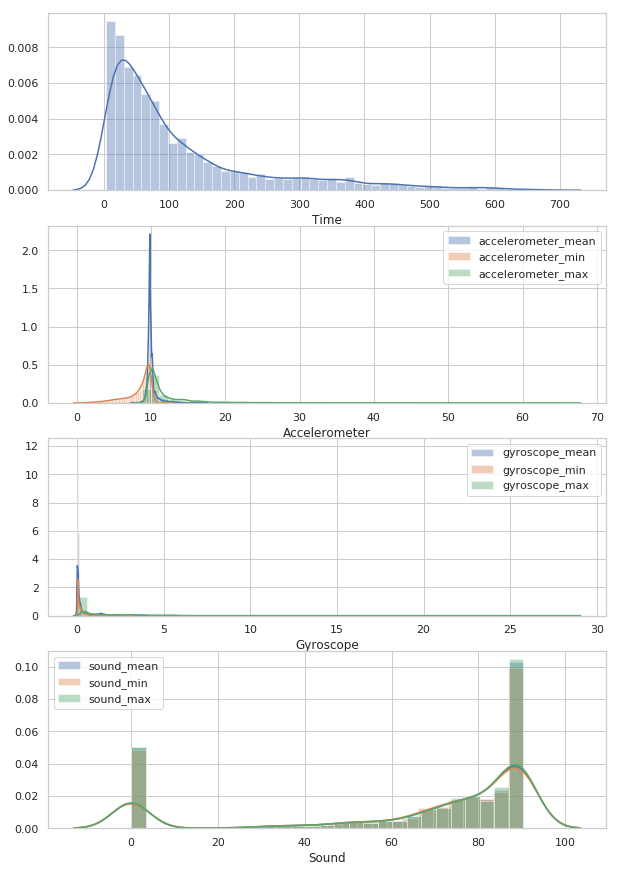

In [9]:
# Verificação da distribuição das variáveis restantes por sensor:

plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
sns.distplot(dataset.iloc[:,0])
plt.xlabel('Time')

plt.subplot(4,1,2)
for i in range(1,4):
    sns.distplot(dataset.iloc[:,i])
plt.legend(dataset.iloc[:,1:4].columns)
plt.xlabel('Accelerometer')

plt.subplot(4,1,3)
for i in range(4,7):
    sns.distplot(dataset.iloc[:,i])
plt.legend(dataset.iloc[:,4:7].columns)
plt.xlabel('Gyroscope')

plt.subplot(4,1,4)
for i in range(7,10):
    sns.distplot(dataset.iloc[:,i])
plt.legend(dataset.iloc[:,7:10].columns)
plt.xlabel('Sound')

plt.show()

In [10]:
# Exclusão das variáveis sound_min e sound_max, que apresentaram correlação máxima com sound_mean:
dataset.drop(['sound_max','sound_min'],axis=1,inplace=True)
dataset.head()

,time,accelerometer_mean,accelerometer_min,accelerometer_max,gyroscope_mean,gyroscope_min,gyroscope_max,sound_mean,target
0,78.0,9.811476,9.758895,9.849411,0.001651,0.000000,0.003533,0.000000,Still
1,145.0,9.939207,7.707437,17.146631,0.036326,0.011669,0.059388,89.200210,Car
2,150.0,9.827178,9.804817,9.849262,0.001525,0.000000,0.002609,0.000000,Still
3,105.0,9.673039,7.659674,12.304298,0.036440,0.020463,0.052512,87.470377,Car
4,77.0,9.993466,8.965621,10.891645,0.183202,0.020667,0.380875,89.770732,Car


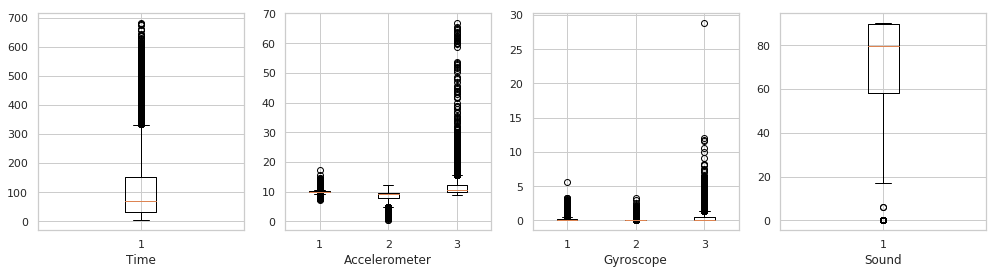

In [11]:
# Verificação dos valores das variáveis restantes através de um boxplot:

plt.figure(figsize=(17,4))

plt.subplot(141)
plt.boxplot(dataset.iloc[:,0])
plt.xlabel('Time')

plt.subplot(142)
plt.boxplot([dataset.iloc[:,1],dataset.iloc[:,2],dataset.iloc[:,3]])
plt.xlabel('Accelerometer')

plt.subplot(143)
plt.boxplot([dataset.iloc[:,4],dataset.iloc[:,5],dataset.iloc[:,6]])
plt.xlabel('Gyroscope')

plt.subplot(144)
plt.boxplot(dataset.iloc[:,7]);
plt.xlabel('Sound')

plt.show()

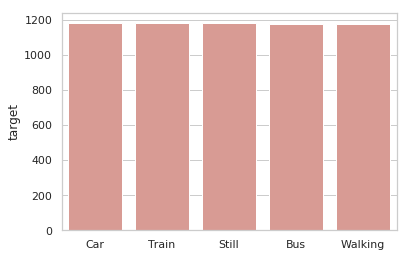

In [12]:
# Verificação da representatividade da variável target no dataset:
sns.barplot(x=dataset.target.value_counts().index,y=dataset.target.value_counts(),color="salmon",saturation=.5);

### 3 – No	caso	do	classificador	Knn,	verifique	o	efeito	do	parâmetro	k	na	classificação.

In [13]:
# Separação do Dataset (também serão utilizados em todos os modelos posteriores a este):
X = dataset.drop(['target'],axis=1)
y = dataset.target

# Separação de datasets para treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

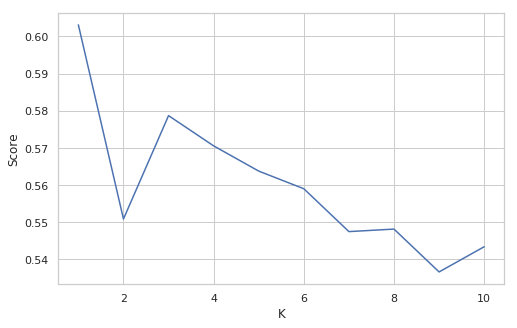

In [14]:
# Desempenho do algorítmo KNN, medido pela acurácia, em função do hiperparâmetro k:

plt.figure(figsize=(8,5))

# Valores de K
K = range(1,11)

# Teste dos modelos
scores = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_test,y_test))

# Resultados
sns.lineplot(K, scores)
plt.ylabel('Score')
plt.xlabel('K')
plt.show()

### 4 – Compare	os classificadores:
* knn (melhor	k	observado	no	item	anterior)
* Naive	Bayes
* Decisão	Bayesiana

In [15]:
# Classificador de Decisão Bayesiana:

class DecisaoBayesiana:
    
    def fit(self, train_x, train_y):
        from scipy.stats import multivariate_normal
        import numpy as np
        import pandas as pd
        
        if type(train_x) != np.ndarray:
            self.train_x = train_x.values
        if type(train_y) != np.ndarray:
            self.train_y = train_y.values
        
        return self
        
    def score(self, test_x, test_y):
        from sklearn.metrics import accuracy_score
        from scipy.stats import multivariate_normal
        
        if type(test_x) != np.ndarray:
            test_x = test_x.values
        if type(test_y) != np.ndarray:
            test_y = test_y.values
        
        classes = y_train.unique()
        train_x = self.train_x
        train_y = self.train_y
        P = pd.DataFrame(data=np.zeros((test_x.shape[0], len(classes))), columns=classes)
        
        for i in np.arange(0, len(classes)):
            elements = tuple(np.where(train_y == classes[i]))
            Z = train_x[elements,:][0]
            m = np.mean(Z, axis = 0)
            cv = np.cov(np.transpose(Z))
            for j in np.arange(0,test_x.shape[0]):
                x = test_x[j,:]
                pj = multivariate_normal.pdf(x, mean=m, cov=cv)
                P[classes[i]][j] = pj
        pred_y = []
        
        for i in np.arange(0, test_x.shape[0]):
            c = np.argmax(np.array(P.iloc[[i]]))
            pred_y.append(classes[c])

        return accuracy_score(test_y, pred_y)

In [16]:
# Seleção de modelos a serem testados:
models = [
    KNeighborsClassifier(n_neighbors=1),
    GaussianNB(),
    DecisaoBayesiana()
]

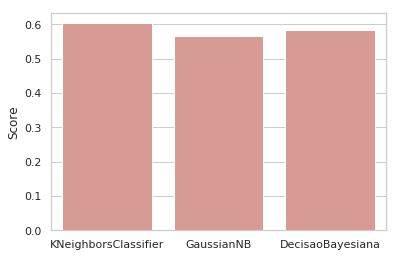

In [17]:
# Desempenho dos algoritmos testados, medido pela acurácia:
scores = []
for model in models:
    model.fit(X_train,y_train)
    scores.append(model.score(X_test,y_test))

# Resultados
sns.barplot(x=[type(m).__name__ for m in models], y=scores, color="salmon", saturation=.5);
plt.ylabel('Score')
plt.show()

### 5 – Verifique	o	efeito	da	normalização (atributos	em	[0,1])	e	padronização (atributos	com	média	0	e	variância	1)	dos	dados.	Compare	os	casos	sem	processamento,	com	padronização	e	com	normalização	para	os	classificadores:
* knn	(melhor	k	observado	no	item	anterior)
* Naive	Bayes
* Decisão	Bayesiana

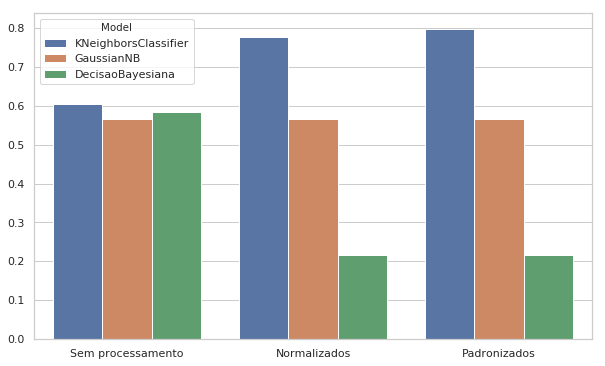

In [18]:
# Desempenho dos modelos testados, medido pela acurácia, com o mesmo conjunto de dados com diferentes pré-processamentos:

# Normalização (min=0 max=1)
X_norm = MinMaxScaler().fit_transform(X)

# Padronização (mean=0 std=1)
X_padr = StandardScaler().fit_transform(X)

# Teste dos modelos
scores = []
for X_currrent,dataset_name in zip([X, X_norm, X_padr],['Sem processamento','Normalizados','Padronizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':dataset_name,'score':score})
scores_df = pd.DataFrame(scores)

# Resultados
plt.figure(figsize=(10,6))
sns.barplot(x=scores_df.dataset, y=scores_df.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.show()

### 6	– Mostre	a	matriz	de	correlação	entre	os	atributos.	Considere	os	atributos	com	menor orrelação	(por	exemplo,	menor	do	que	0.5).	Realize	a	classificação novamente	apenas	com	esses	atributos.	A acurácia	melhora?

In [19]:
# Transformação de target para variável numérica:
dataset_ex6 = dataset.copy()
dataset_ex6.target = LabelEncoder().fit_transform(dataset_ex6.target)
dataset_ex6.sample(5)

,time,accelerometer_mean,accelerometer_min,accelerometer_max,gyroscope_mean,gyroscope_min,gyroscope_max,sound_mean,target
796,583.0,10.152312,10.113324,10.184769,0.005650,0.001485,0.015989,85.584667,3
3360,60.0,11.375513,6.238092,17.554287,1.681855,0.441350,3.804648,89.712441,4
3517,6.0,10.372952,4.221173,14.658966,0.656682,0.299185,1.680802,76.998211,4
3616,259.0,9.931928,9.903832,9.946624,0.008859,0.001436,0.022296,89.665468,2
660,331.0,9.815316,9.643778,10.110356,0.026634,0.005730,0.047538,62.771699,2


In [23]:
# Correlações com target:
correlations = dataset_ex6.corr()
correlations[['target']]

,target
time,0.072385
accelerometer_mean,0.390777
accelerometer_min,-0.282127
accelerometer_max,0.332857
gyroscope_mean,0.458095
gyroscope_min,0.335379
gyroscope_max,0.407644
sound_mean,0.010029
target,1.000000


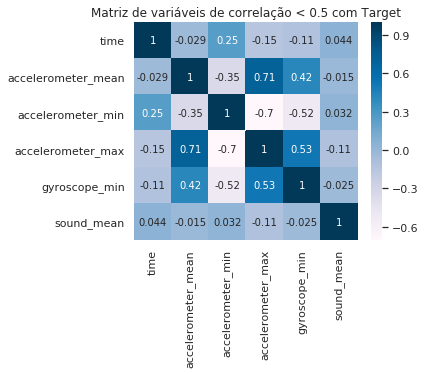

In [24]:
# Matriz de correlação entre novas as variáveis:

X_low_corr = dataset_ex6.drop(['target'],axis=1)
y_low_corr = dataset_ex6.target

X_low_corr = X_low_corr[correlations[correlations.target<0.4].index]

plt.figure(figsize=(5,4))
plt.title('Matriz de variáveis de correlação < 0.5 com Target')
sns.heatmap(X_low_corr.corr(), cmap='PuBu',annot=True)

plt.show()

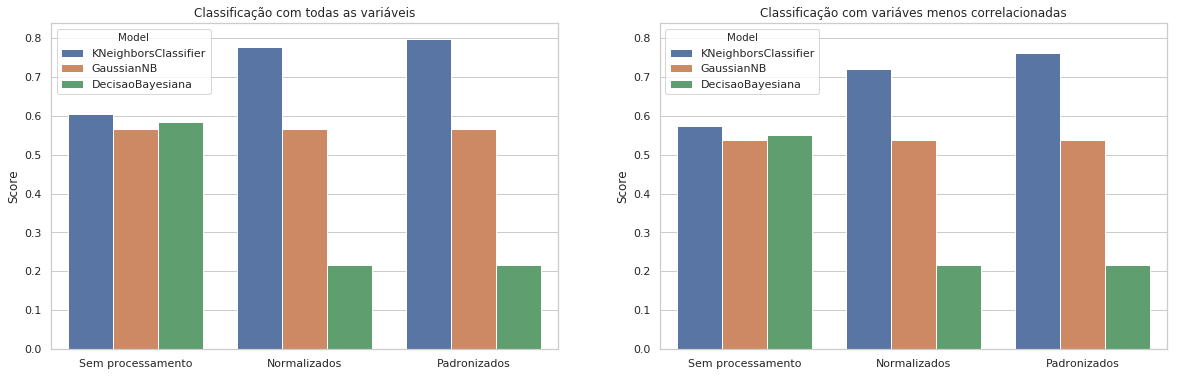

In [25]:
# Normalização (min=0 max=1)
X_low_corr_norm = MinMaxScaler().fit_transform(X_low_corr)

# Padronização (mean=0 std=1)
X_low_corr_padr = StandardScaler().fit_transform(X_low_corr)

# Teste dos modelos
scores = []
for X_currrent,base in zip([X_low_corr, X_low_corr_norm, X_low_corr_padr],
                           ['Sem processamento','Normalizados','Padronizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':base,'score':score})
scores_df_low_corr = pd.DataFrame(scores)

# Resultado
plt.figure(figsize=(20,6))

ax = plt.subplot(121)
sns.barplot(x=scores_df.dataset, y=scores_df.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.ylabel('Score')
plt.title('Classificação com todas as variáveis')

plt.subplot(122, sharey=ax)
sns.barplot(x=scores_df_low_corr.dataset, y=scores_df_low_corr.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.ylabel('Score')
plt.title('Classificação com variáves menos correlacionadas')

plt.show()

### 7	– Verifique	qual	dos	classificadores	é	mais	robusto	com	relação	à	presença	de	ruídos.	Para	isso:	
* Aplique	a	normalização	dos	dados	para	que	os	atributos	apresentem	média	igual	a	zero	e	variância	igual	a	1.
* Inclua	em	X%	dos	atributos,	um	valor	normalmente	distribuído	com	média	0	e	variância 1. Considere	toda	a	matriz	dos	dados,	sorteando uma	posição	da	matriz	de	forma	aleatória.

* Varie	o	nível	de	ruído,	de	0	a	50%	(em	passos	de	5%)	e	avalie	como	muda a	classificação.	Construa	um	gráfico	de	X% de	ruído versus	porcentagem	de	classificação	correta.	Coloque	a	média	e	o	desvio	padrão	calculados	a partir	de	ao	menos	10	simulações.	Considere	70%	dos	dados	no	conjunto de	treinamento.
* Discuta os	resultados.

In [26]:
# Normalização

# Ruído

### 8 – No	caso	do	classificador	Naive	Bayes,	é	possível	considerar	diferentes funções	para	estimar	as	probabilidades.	Compare	os	casos:
1. Gaussian	Naive Bayes
2. multinomial	Naive	Bayes
3. Bernoulli	Naive	Bayes.
#### Considere os casos	com	e	sem	padronização.

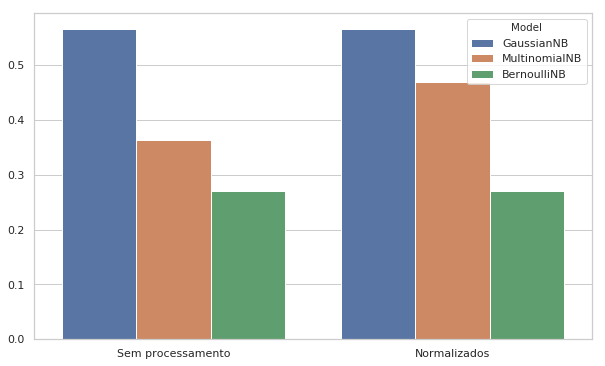

In [27]:
# Desempenho dos modelos gausianos, medido pela acurácia, com o mesmo conjunto de dados com diferentes pré-processamentos:

# Normalização (min=0 max=1)
X_norm = MinMaxScaler().fit_transform(X) 
                                         
# Seleção de modelos gausianos
gausian_models = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB()
]

# Teste dos modelos
scores = []
for X_currrent,base in zip([X, X_norm],['Sem processamento','Normalizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in gausian_models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':base,'score':score})
scores_df = pd.DataFrame(scores)

# Resultado
plt.figure(figsize=(10,6))
sns.barplot(x=scores_df.dataset, y=scores_df.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.show()

### 9 – No	caso	do	Knn,	compare	as	classificações	usando	diferentes	métricas.	Varie	k	e	mostre	as	curvas	(em	um	mesmo	plot)	para	as	distâncias	euclidiana,	Manhattan,	Chebyshev e	Minkowsky	(p=0.5,	p=1.5,	p	=	3).


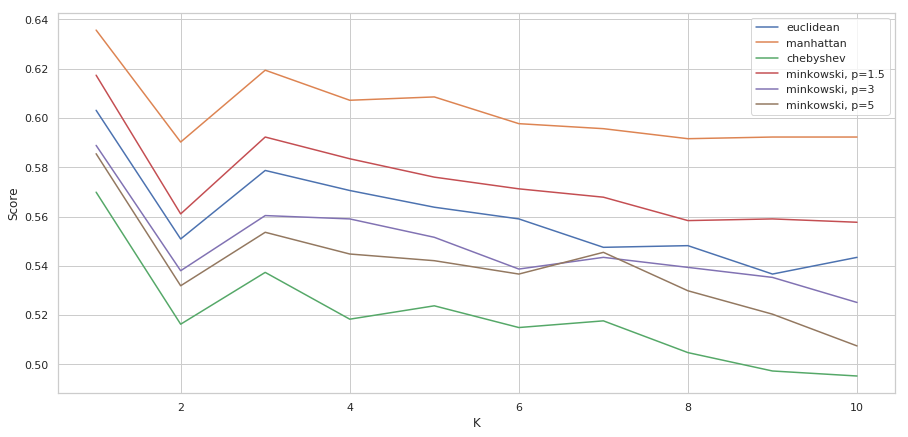

In [28]:
# Desempenho dos modelo KNN, medido pela acurácia, em função do hiperparâmetro k, com diferentes distâncias:

plt.figure(figsize=(15,7))

# Ks a serem utilizados pela curva
K = range(1,11)

# Distâncias
metrics = ['euclidean','manhattan','chebyshev']

# Testes dos modelos
for m in metrics:
    scores = []
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
        knn.fit(X_train,y_train)
        scores.append(knn.score(X_test,y_test))
    sns.lineplot(K, scores)
    
for p in [1.5,3,5]:
    scores = []
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k,metric='minkowski',p=p)
        knn.fit(X_train,y_train)
        scores.append(knn.score(X_test,y_test))
    metrics.append('minkowski, p={}'.format(p))
    sns.lineplot(K, scores)

# Resultados
plt.legend(metrics)
plt.ylabel('Score')
plt.xlabel('K')
plt.show()

### 10	– Faça	um	gráfico	da	fração	de	elementos	no	conjunto	de	treinamento	(10% até	90%	em	passos	de	10%)	versus	acurácia	para	os	classificadores:
* knn	(melhor	k	observado	anteriormente)
* Naive	Bayes
* Decisão	Bayesiana
### Considere	os	casos	com	e	sem	padronização.

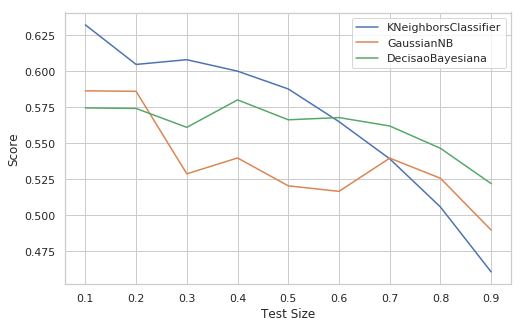

In [29]:
# Desempenho dos modelos testados, medido pela acurácia, em função do matanho do dataset de treinamento:

plt.figure(figsize=(8,5))

# Valores para test_size
P = [i/10 for i in range(1,10)]

# Teste dos modelos
for model in models:
    scores = []
    for p in P:
        X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X,y,random_state=42,test_size=p)
        model.fit(X_p_train,y_p_train)
        scores.append(model.score(X_p_test,y_p_test))
    sns.lineplot(P, scores)

# Resultados
plt.legend([type(m).__name__ for m in models])
plt.ylabel('Score')
plt.xlabel('Test Size')
plt.show()